# Debiasing with Propensity Score
 
직교화는 처치(`treatment`)와 결과(`outcome`)에 대한 잔차를 기반으로 하는 방법입니다. 직교화를 통해 편향된 데이터를 무작위만큼 좋아 보이게 할 수 있었습니다.

$
t^* = t - M_t(X)
$
 
$
y^* = y - M_y(X)
$
 
직교화는 연속, 범주형 처치 모두에 적용할 수 있는 강력한 기술입니다. 

여기서는 `propensity score`(성향 점수)를 기반으로 하는 방법을 배워보겠습니다. 성향 점수는 범주형 처치에서만 잘 적용되는 단점이 있지만 일부 상황에서는 직교화보다 더 나은 결과를 주기도 하므로 충분히 배울 가치가 있습니다. 

앞에서 살펴본 아이스크림 가격은 연속적인 처치를 다루고 있으므로 여기서는 이진 처치에 해당하는 이메일 데이터를 사용합니다. 참고로 연속 처치를 범주형으로 보이도록 이산화하는 방법을 사용할 수 있습니다. (예를 들어, 연속적인 가격을 [2.00, 4.00, 6.00, 8.00]와 같이 R$ 2.00 단위로 나누어 이산화할 수 있습니다.) 이제 이메일 데이터를 자세히 살펴봅시다. 

상황은 다음과 같습니다. 당신은 생명 보험, 저축 계좌, 투자 계좌 등과 같은 금융 상품을 판매하는 금융 회사에서 일하고 있습니다. 당신은 회사에서 개발한 새로운 상품을 홍보하고자 합니다. 홍보를 위해 영업 부서는 `em1`, `em2`, `em3` 총 $3$종류 이메일을 발송했습니다.
 
영업팀은 통계학 및 실험 설계에 대한 교육을 매우 잘 받았기 때문에 단순히 모든 사람에게 이메일을 보내지 않았습니다. 대신 확률적으로 이메일을 발송하는 실험을 설계합니다. 확률은 이메일 응답에 대한 비즈니스적 경험에 기초합니다. 예를 들면 `em1`은 투자 경험이 없으며 수입이 적은 대중적인 고객을 대상으로 발송합니다. 일반적인 사람들은 `em1`을 받을 확률이 높습니다. 확률이 정해지면 확률에 따라 무작위 고객에게 이메일을 발송합니다.
 
![img](./data/img/debias-ps/ps-experiment.png)
 
참고로 이는 비즈니스적 전문 지식을 활용하는 동시에 마케팅 전략이 얼마나 효과적인지에 대한 유효한 추론을 할 수 있는 가장 좋은 방법입니다. 영업팀은 확률에 따라 무작위로 이메일을 할당하면서 각 고객에 대해 확률을 기록해두었습니다.
 
실험 데이터는 다음과 같습니다. 먼저 고객을 특정할 수 있는 `age`(나이), `income`(소득), `insuracne`(보험액), `invested`(투자액)이 포함됩니다. 이는 영업팀이 이메일을 발송하는 확률을 결정하는데 사용하는 변수입니다. 결정된 확률은 `em1_ps`, `em2_ps`, `em3_ps`에 기록합니다. 실제로 고객이 광고 메일을 받았는지는 `em1`, `em2`, `em3`에 표기됩니다. `em1`, `em2`, `em3`는 처치에 해당합니다. `converted`는 결과로 금융 자문 서비스 계약 여부를 의미합니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

email = pd.read_csv("./data/invest_email.csv")
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


일부 고객은 `em1`을 받을 확률이 매우 낮습니다. 고객 $2$는 `em1`을 받을 확률이 $0.062$로 실제로 `em1`을 받지 못했습니다. 이메일을 받을 확률을 고려하면 놀라운 일은 아닙니다.
 
하지만 어떤 고객은 `em1_ps`가 높지만 이메일을 받지 못합니다.

In [2]:
email.query("em1 == 0 and em1_ps > 0.9")

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
2438,48.0,538.02,26276.38,1582.82,0.913562,0.008951,0.999208,0,0,1,1
2692,44.2,545.62,2377.01,743.40,0.901065,0.004204,0.999047,0,0,1,0
3152,44.6,541.42,13272.96,1455.92,0.907929,0.008233,0.999136,0,0,1,1
4175,38.0,543.20,16787.28,1302.20,0.905007,0.007364,0.000000,0,0,0,1


## Inverse Probability of Treatment Weighting
 
![img](./data/img/debias-ps/again.png)
 
편향 제거 측면에서 성향 점수를 요약하면 (성향 점수 파트에서 이미 논의했습니다.) 우리는 위와 같은 고객 ($2438$, $2692$, $3152$, $4175$)에 매우 관심 있습니다. 이들은 이메일을 받을 확률이 높으므로 `em1`을 받는 고객과 많이 닮아있습니다. 하지만 메일을 받지는 못했습니다. 따라서 반사실적 결과 $Y_0|em1=1$를 추정할 수 있는 훌륭한 후보가 될 수 있습니다.
 
성향 점수는 처치 받은 것처럼 보이지만 실제로는 처치를 받지 못한 데이터에 더 많은 가중치를 주는 방식으로 작동합니다. 가중치를 주는 방식은 매우 간단합니다. **모든 unit에 대해 처치 받을 확률의 역수를 가중치로 부여합니다**. `unit`이 처치 받았다면 $1/P(treatment=1)$ 만큼 가중치를 줍니다. 처치 받지 못했다면 $1/P(treatment=0)$ 또는 $1/P(control)$ 만큼 가중치를 줍니다. 이진 처치는 가장 단순한 형태를 가집니다.

$$
W_i = \dfrac{T}{P(T=1|X)} + \dfrac{1-T}{1-P(T=1|X)}
$$
 
`treatment` 범주가 여럿이라도 아래와 같이 일반화할 수 있습니다.
 
$$
W_i = \sum^K_{k=0} \dfrac{\mathcal{1}_{K=k} }{P(T=k|X)}
$$
 
성향 점수가 어떻게 작동하는지 확인해 보기 전에 편향이 있는 경우 어떤 일이 생기는지 알아봅시다. 데이터에는 `age`(나이), `income`(소득), `insuracne`(보험액), `invested`(투자액) 등 교란자가 포함되어 있습니다.

In [3]:
confounders = ["age", "income", "insurance", "invested"]

`treatment`인 `em1`과 상관관계를 확인해 보면 이들이 정말로 교란 변수라는 것을 알 수 있습니다.

In [4]:
email[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.058796,0.401759
income,-0.305610,-0.054009
insurance,-0.023948,-0.076234
invested,-0.242374,-0.030250
em1,1.000000,0.046598
converted,0.046598,1.000000


편향을 설명하지 못하면 인과 추론 결과가 잘못될 수 있습니다. `invested`를 예를 들어봅시다. **적은** 투자액은 상품 가입 가능성을 **높이며** 이메일을 받을 가능성 또한 **높게 합니다**. 따라서 `invested`를 통제하지 않으면 `em1`이 `converted`를 높이는 것처럼 보일 것입니다. 하지만 이는 낮은 수준의 투자액이 더 높은 가입과 더 높은 `em1`을 만들 수 있어 인과관계가 아닌 상관관계일 수 있습니다.

교란 변수와 상관관계 외에도 `em1`을 받은 사람과 받지 못한 사람 간 분포의 차이가 어떻게 보이는지 확인할 수 있습니다.

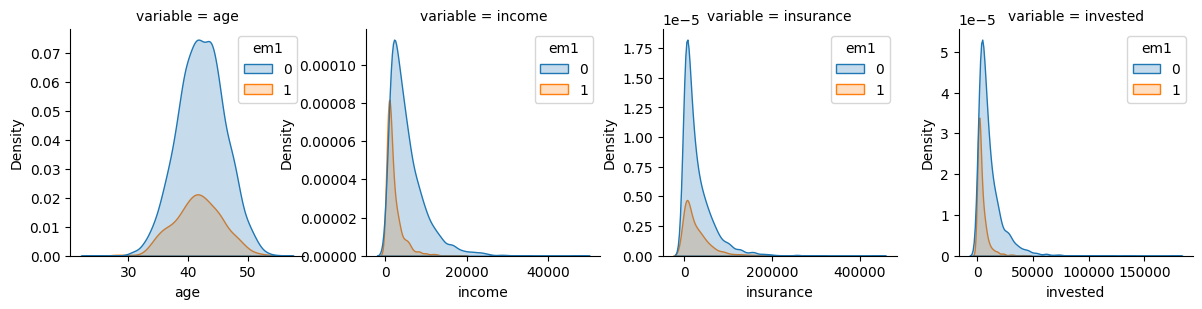

In [5]:
plt_df = pd.melt(email[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

### Stored Propensity Score
 
`em1` 할당이 실제로 편향되었음을 확인했으니 성향 점수로 편향을 줄여봅시다. 여러분은 직교화를 떠올릴지도 모르겠습니다. 왜 직교화를 사용할 수 없을까요? 저는 직교화 대신 성향 점수를 사용하고자 합니다. 매우 좋은 질문이지만 명확한 답을 가지고 있지 않습니다. 하지만 성향 점수를 사용해야 할 분명한 때가 있습니다.

실험을 수행하는 동안 처치 받을 확률을 저장했다면 **모델이 없어도 성향 점수로 편향을 제거할 수 있습니다.** 이미 처치 받을 확률을 알고 있기 때문입니다. 이는 큰 장점입니다. 모델은 결코 완벽할 수 없기 때문입니다. 모델은 편향을 완벽히 제거하지 못합니다. 앞에서 우리는 처치 확률을 `em1_ps`, `em2_ps`, `em3_ps`에 정리했습니다.

지금은 `em1`만 다루고 있으므로 `em1_ps`만 있으면 됩니다. 먼저 위 공식으로 개별 `unit`에 대한 가중치를 만듭니다. 그리고 가중치를 사용해 데이터를 다시 샘플링합니다. 가중치가 $2$인 `unit`은 가중치가 $1$인 `unit`에 비해 두 배 더 자주 샘플링될 것입니다.

In [6]:
np.random.seed(123)
em1_rnd = email.assign(
    em1_w = email["em1"]/email["em1_ps"] + (1-email["em1"])/(1-email["em1_ps"])
).sample(10000, replace=True, weights="em1_w")

In [7]:
np.random.seed(5)
em1_rnd.sample(5)

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,em1_w
2252,44.0,5102.43,42300.28,2294.60,0.097928,0.012976,0.902465,0,0,1,0,1.108559
4364,44.0,8503.72,751.08,33314.37,0.058805,0.188387,0.830375,1,0,0,1,17.005333
752,44.4,1778.21,24615.45,3054.08,0.279973,0.017270,0.972922,1,0,1,1,3.571777
3656,39.8,1752.18,487.22,1893.95,0.284108,0.010710,0.000000,0,0,0,0,1.396859
4613,43.1,1023.04,64695.01,2220.32,0.484638,0.012556,0.988928,0,0,1,1,1.940382


샘플링은 편향이 없는 새로운 데이터 세트를 만들어야 합니다. 처치된 것처럼 보이지만(높은 `em1_ps`) 처치되지 않은 `unit`이나 대조군처럼 보이지만(낮은 `em1_ps`) 처치된 `unit`을 오버샘플링 해야 합니다.

`treatment`와 `confounder`의 상관관계를 확인해 보면 상관관계가 사라졌음을 확인할 수 있습니다.

In [8]:
em1_rnd[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.021004,0.404736
income,-0.026685,-0.037946
insurance,-0.037656,-0.071385
invested,-0.012073,-0.047987
em1,1.000000,0.076342
converted,0.076342,1.000000


또한, 할당된 처치 별로 교란 변수 분포가 잘 정렬되어 있음을 확인할 수 있습니다. 편향을 줄인다는 직접적인 증거는 아니지만 충분히 좋습니다.

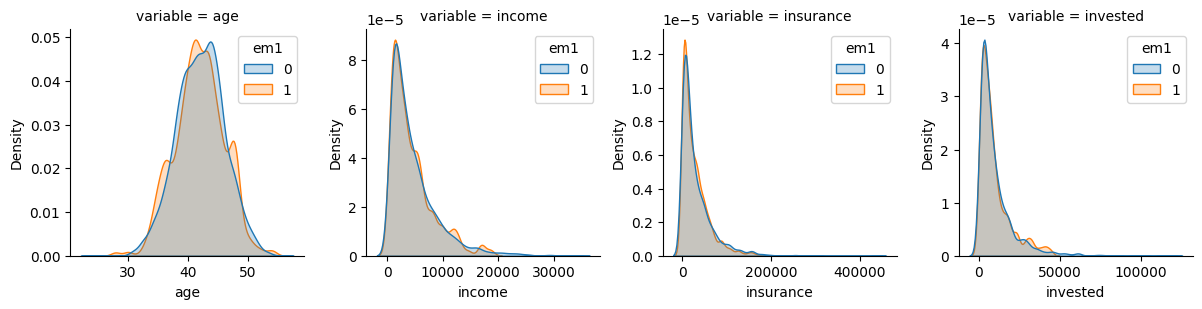

In [9]:
plt_df = pd.melt(em1_rnd[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

새로운 데이터 세트는 편향이 제거되었습니다. 이 데이터는 모델을 평가나 다른 분석에 사용할 수 있습니다. 하지만 한가지 주의해야 할 점이 있습니다. 총 $10000$개 데이터를 샘플링했는데, 원래 데이터는 총 $5000$개 였습니다. 리샘플링은 데이터를 원하는 만큼 크게 만들 수 있어 인위적으로 부풀릴 수 있습니다. 표본 크기가 커질 수 있다는 점을 고려하지 않으므로 계산된 신뢰 구간은 유효하지 않을 것입니다.
 
리샘플링은 매우 효과적입니다. 애초에 확률을 정확히 알고 있으므로 작업이 쉬웠습니다. 확률을 모르고 있다면 어떨까요? 주어진 `confounder`와 `treatment`에만 접근할 수 있다고 생각해 봅시다.
 
### Estimated Propensity Score
 
이제 성향 점수를 추정해야 합니다. 이러한 상황에서는 편향을 제거하기 위해 직교화와 성향 점수 중 어느 것을 사용해야 할지 명확하지 않습니다.
 
성향 점수는 기계 학습 모델로 추정할 것입니다. 성향 점수는 처치 확률과 밀접한 관련이 있으므로 기계 학습 모델이 유용합니다. 과적합을 고려하기 위해 교차 검증이 필요합니다.

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

t = "em1"

folds = 5

np.random.seed(123)

# makes calibrated Random Forest. 
m_t = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, min_samples_leaf=40, max_depth=3),
    cv=3
)

# estimate PS with cross prediction. 
ps_score_m1 = cross_val_predict(m_t, email[confounders], email[t],
                                cv=folds, method="predict_proba")[:, 1]

In [11]:
email.assign(ps_score_m1_est = ps_score_m1).head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,ps_score_m1_est
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1,0.107973
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0,0.403693
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0,0.082788
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0,0.084226
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0,0.727700


성향 점수 추정치인 `ps_score_m1_est`는 실제 성향 점수 `em1_ps`에 가깝지만 같지는 않습니다. 이 차이가 영향이 있겠지만 크지는 않길 바랍니다. 성향 점수를 얼마나 잘 추정하고 있는지 확인해 봅시다. 이를 위해 평균 `em1`에 대한 평균 점수를 계산합니다. 점수가 잘 추정되었다면 점수가 $0.2$인 사람 중 $20$%가 `em1`을, $0.3$인 사람 중 $30$%가 `em1`을 받았을 것입니다.

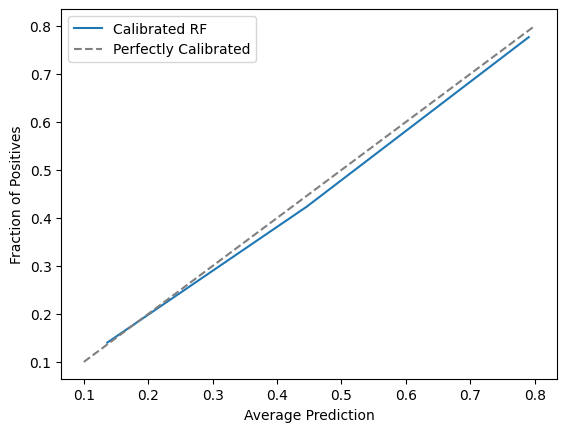

In [12]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(email["em1"], ps_score_m1, n_bins=3)
plt.plot(prob_pred, prob_true, label="Calibrated RF")
plt.plot([.1,.8], [.1, .8], color="grey", linestyle="dashed", label="Perfectly Calibrated")
plt.ylabel("Fraction of Positives")
plt.xlabel("Average Prediction")
plt.legend();

이제 성향 점수 참값을 알고 있는 것처럼 진행할 수 있습니다.

In [13]:
np.random.seed(123)
em1_rnd_est = email.assign(
    em1_w = email["em1"]/ps_score_m1 + (1-email["em1"])/(1-ps_score_m1)
).sample(10000, replace=True, weights="em1_w")

편향을 제거했음에도 여전히 처치와 교란 변수 사이에 강한 상관관계를 확인할 수 있습니다. 예를 들어 `em1`과 `income`과의 상관관계는 $-0.15$로, 편향된 데이터의 $-0.3$ 보다는 괜찮지만, 성향 점수 참값으로 만들어진 데이터의 $0.02$보다는 훨씬 높습니다. `invested`도 마찬가지입니다.

In [14]:
em1_rnd_est[confounders + ["em1"]].corr()["em1"]

age         -0.025840
income      -0.151268
insurance   -0.036037
invested    -0.108351
em1          1.000000
Name: em1, dtype: float64

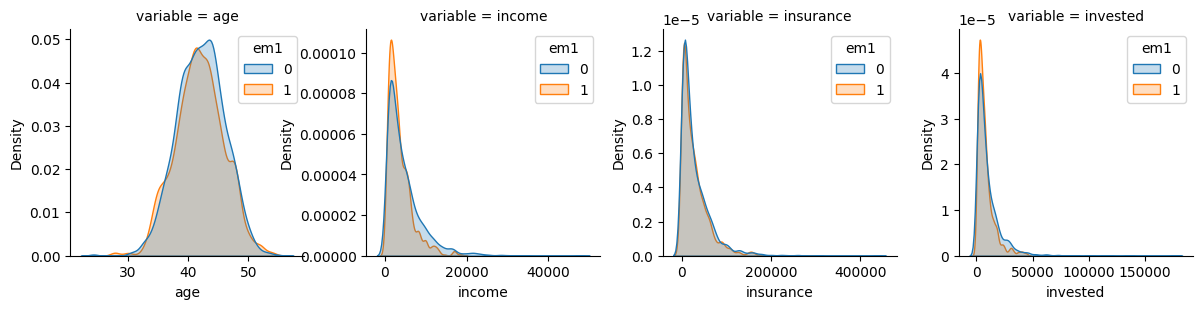

In [15]:
plt_df = pd.melt(em1_rnd_est[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

분포를 그려보면 `income`과 `invested`에서 약간 다르다는 것을 확인할 수 있습니다.
 
## The Weakness of Propensity Score
 
성향 점수의 약점은 높거나 너무 낮은 값과 관련이 있습니다.

![img](./data/img/debias-ps/fear-no-man.png)
 
원본 데이터에서 $1014$ 번째 데이터를 확인해 봅시다.

In [16]:
email.loc[[1014]]

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
1014,43.2,18628.09,30356.68,28335.68,0.026862,0.160233,0.615788,1,0,0,1


이 데이터는 `em1`에 대해 $0.027$의 성향 점수를 가집니다. 가중치는 약 $37 ( = 1 / 0.027 )$ 입니다. 따라서 데이터를 샘플링할 때 $37$ 배나 많이 뽑히게 됩니다.

In [17]:
em1_rnd.loc[[1014]].shape

(38, 12)

하나의 데이터가 너무 많이 나타나는 것은 문제입니다. 만약 이 데이터가 원래 데이터에 없었다면 편향이 제거된 데이터 세트는 완전히 다르게 보일 수 있습니다. 또한, 분산이 높아질 수 있습니다.

샘플링된 데이터에서 각 `unit`에 대한 빈도수를 표시하면 특정 데이터가 $10$회 이상 나타나는 것을 확인할 수 있습니다. 이러한 `unit`이 낮거나 높은 성향 점수를 가지고 있습니다.

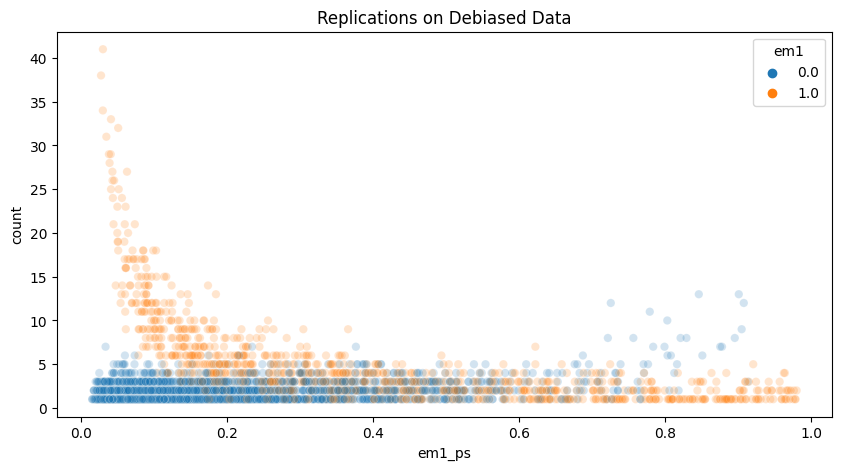

In [18]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=em1_rnd.assign(count=1).groupby(em1_rnd.index).agg({"count":"count", "em1_ps": "mean", "em1": "mean"}),
    x="em1_ps",
    y="count",
    hue="em1",
    alpha=0.2
)
plt.title("Replications on Debiased Data");

특정 `unit`이 지나치게 많이 나타나는 것을 피하고자 일부 과학자는 가중치를 잘라내는 것을 좋아합니다. 예를 들면 가중치 최댓값이 $20$이 되도록 합니다. 가중치를 제한하는 것은 분산을 줄여주긴 하지만 편향을 만들 수 있습니다. 우리의 목적은 편향을 제거하는 것이므로 이 방법이 좋다고 생각하지 않습니다.
 
개인적으로 가장 좋은 방법은 실험 설계를 세심히 하는 것으로 생각합니다. 너무 가중치가 높지 않도록 해야 합니다. 즉, 가능한 모든 사람에게 같은 확률로 `treatment`를 제공하도록 노력하세요.
 
전체 표본 또는 하위 모집단에 대해 처치나 통제받을 확률이 너무 낮으면 모든 인과 추론 방법이 어려워집니다. 이는 일부 `unit`는 처치나 통제받지 못한다는 것을 의미하며 반사실을 추정하는 것을 어렵게 만듭니다. 이는 다음에 살펴볼 `common support assumption`을 위반한 것으로 볼 수 있습니다.

## Positivity or Common Support
 
`positivity`, `common support`는 실험군과 대조군 사이에 충분한 중첩이 있어야 한다는 인과 추론 기본 가정입니다. 즉, 모든 사람에 대해 처치 혹은 통제받을 확률은 $0$이 될 수 없습니다. 이 가정이 만족하지 않는다면 전체에 대한 인과 효과를 추정할 수 없게 됩니다.
 
`positivity`는 데이터 자체의 문제로 성향 점수의 문제는 아닙니다. 하지만 성향 점수로 `positivity`를 명확히 확인할 수 있습니다. 이러한 의미에서 성향 점수는 매우 유용합니다. 대부분 방법은 `positivity` 문제를 알려주지 않지만, 성향 점수는 직접적으로 보여줍니다. 실험군과 대조군의 성향 점수의 분포를 그려보면 쉽게 알 수 있습니다.

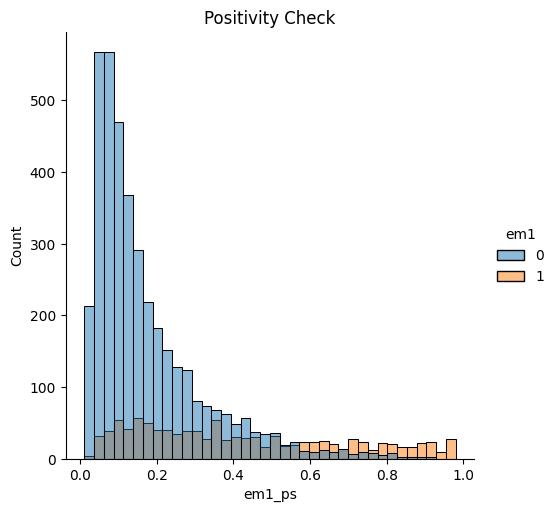

In [19]:
sns.displot(data=email, x="em1_ps", hue="em1")
plt.title("Positivity Check");

위와 같이 서로 겹치는 부분이 있다면 `common support`를 만족하는 것입니다. 이제 `em3`를 살펴봅시다.

In [20]:
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


확률이 $0$인 `unit`이 눈에 띕니다. 이 데이터는 `positivity` 가정을 위반하고 있습니다. `em3`에 대해 `feature`의 분포를 확인해 보겠습니다.

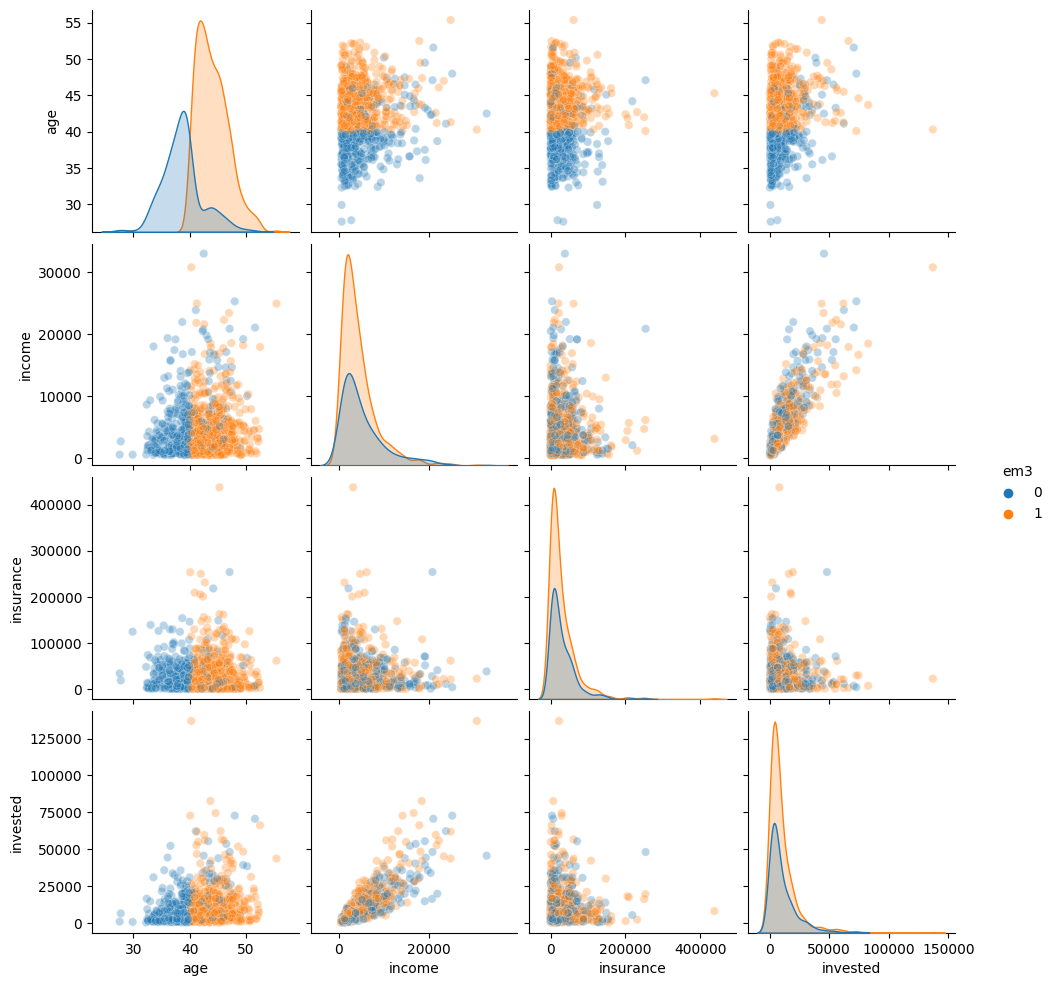

In [21]:
sns.pairplot(email.sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3));

`em3`는 $40$ 세 이상 고객에게만 발송된 것으로 보입니다. 이는 큰 문제를 만드는데, 대조군에만 젊은 사람이 있다면 반사실 $Y_0|T=1, age<40$를 추정할 수 없습니다. 젊은 고객이 `em3`에 어떻게 응답할지 모르기 때문입니다.
 
성향 점수로 편향되지 않은 버전의 데이터를 만들어 봅시다.

In [22]:
em3_weight = (email
              # using a different implementation to avoid division by zero
              .assign(em3_w = np.where(email["em3"].astype(bool), 1/email["em3_ps"], 1/(1-email["em3_ps"])))
              .sample(10000, replace=True, weights="em3_w"))

In [23]:
em3_weight[confounders + ["em3"]].corr()["em3"]

age          0.251035
income       0.047607
insurance   -0.000961
invested     0.053524
em3          1.000000
Name: em3, dtype: float64

나이와 처치 사이에는 여전히 큰 상관관계가 있습니다. $40$ 세 이하의 데이터를 처리하지 않으므로 나이로 인한 편향을 없애지 못합니다. `positivity`를 확인하기 위해 실험군과 대조군의 성향 점수 분포를 그려봅시다.

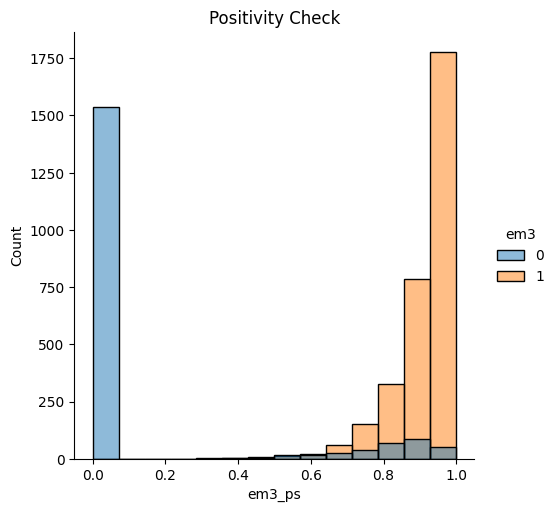

In [24]:
sns.displot(data=email, x="em3_ps", hue="em3")
plt.title("Positivity Check");

겹치는 영역이 적어 보입니다. 성향 점수가 $0.4$보다 작은 `unit`은 거의 처치되지 않습니다. $0$의 거대한 봉우리는 말할 것도 없습니다.
 
### Positivity In Practice
 
학문적으로는 `positivity`에 대한 문제는 일반화를 다루고 있어 매우 중요합니다. 만약 나이가 많은 고객에 대해서는 처치했다면, 젊은 사람들에 대해서는 처치 효과를 발견하더라도 일반화할 수 없기 때문입니다. 하지만 실무에서는 큰 문제가 아닐 수도 있습니다.

예를 들어 채무 불이행 확률에 대해 대출 금액의 탄력성을 추정하고자 할 때, 당신이 은행 직원이라면 아마 신용 점수가 매우 낮은 사람들에게 높은 대출을 주지 않을 것입니다. 물론 이는 `positivity` 가정을 위배합니다. 하지만 어쨌든, 그들에게 대출해줄 의도가 없으므로 이들의 인과 효과를 추정하는 데는 큰 관심이 없습니다. 또는, 상품의 가격 탄력성을 추정하려는 경우 $0$ 원에 대한 가격 탄력성은 확인하지 않을 것입니다. 상식적으로 정상적인 가격 범위를 알고 있으며 이 범위 내 가격 탄력성에 관심이 있습니다.
 
요점은 배경지식을 활용해 모집단 중 일부를 처치(또는 통제) 받지 못하도록 배제할 수 있다는 것입니다. 무작위 실험은 비용이 많이 들기 때문에, 더 효과적인 범위에 집중해야 합니다.
 
이메일 예시에서는 홍보팀이 젊은 사람들에게 `em3`를 절대로 보내서는 안 된다고 생각했을 것입니다. 아마도 나이 든 사람들만이 공감할 수 있는 내용이었을 것입니다. `em3`에 대해서는 40세 이상 고객에 미치는 영향만 추정할 수 있습니다. 이 정도 결과도 괜찮습니다. `em3`에 대한 영향은 젊은 고객까지 일반화할 수 없다는 사실만 유의하면 됩니다.

이러한 점을 고려해 `em3`의 편향을 제거해봅시다. $40$ 세 이하 고객 데이터를 제거합니다.

In [25]:
em3_weight.query("age>40")[confounders + ["em3"]].corr()["em3"]

age         -0.034455
income       0.024633
insurance   -0.005650
invested     0.020711
em3          1.000000
Name: em3, dtype: float64

이제 처치와 교란 변수 사이의 상관관계가 줄어듭니다. 원본 데이터에서는 나이와의 상관관계가 $0.2$보다 높았지만 $-0.03$로 줄어들었습니다. 전체 데이터 분포를 확인해 봅시다.

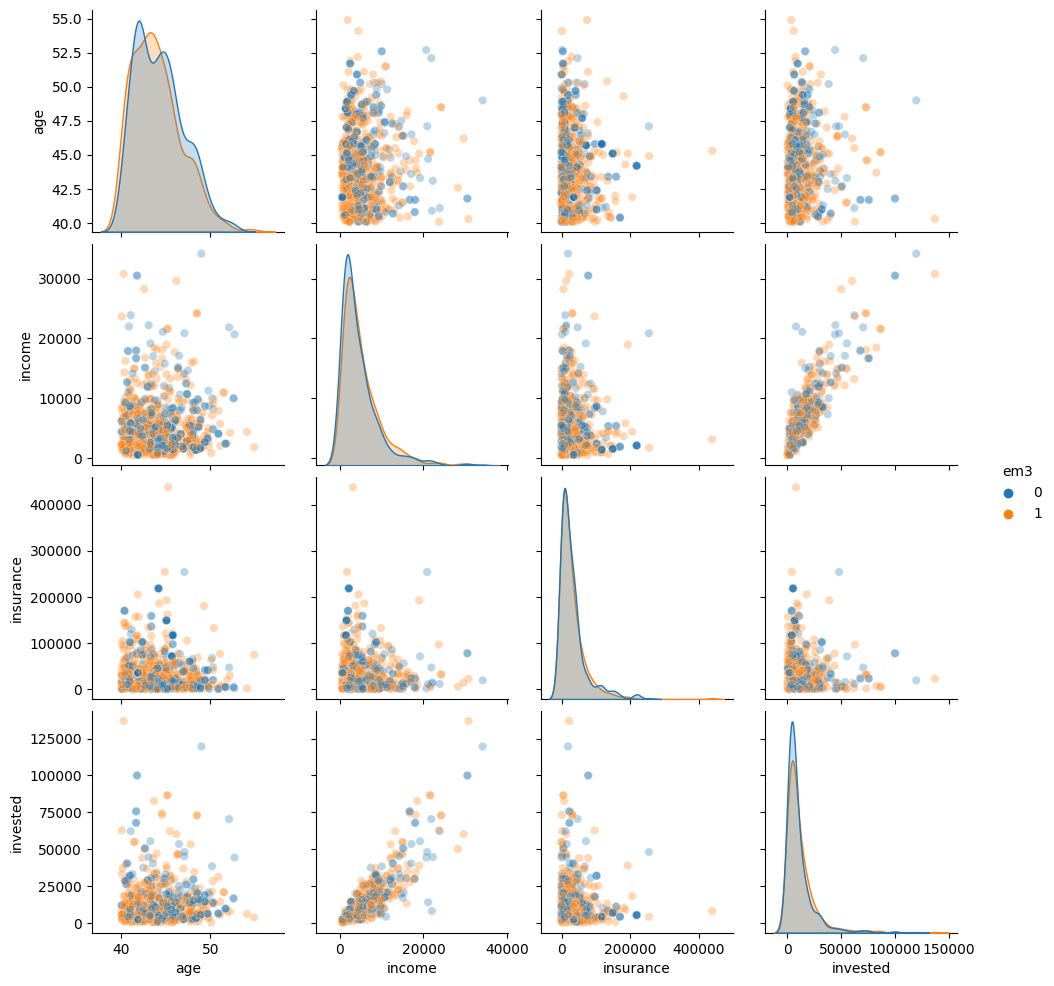

In [26]:
sns.pairplot(em3_weight.query("age>40").sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3))

`positivity` 가정 위반으로 모든 데이터에서 `em3`에 대한 편향을 제거할 수는 없습니다. 그래도 `em3`가 설계된 모집단에 대해서는 편향을 없앨 수 있습니다. 이 정도면 충분합니다.
 
## Key Ideas
 
이번 장에서는 범주형 처치에 대해 편향을 제거할 수 있는 아이디어를 살펴보았습니다. 방법은 성향 점수를 활용해 데이터를 다시 샘플링하는 것입니다. 실험군처럼 보이지만(높은 성향 점수) 대조군인 데이터와 대조군처럼 보이지만(낮은 성향 점수) 실험군인 데이터를 더 많이 뽑습니다.

성향 점수의 큰 장점은 실험 중에 처치 확률을 지정하면 모델이 필요하지 않다는 것입니다. 확률을 모른다면 모델을 사용할 수 있지만 추가적인 편향이 생길 수 있습니다.
 
성향 점수의 단점은 점수가 너무 높거나 낮아 가중치를 커지면 같은 데이터가 너무 많이 뽑힐 수 있습니다. 이러한 문제는 실험군처럼 보이는 대조군이 없으면 (혹은 대조군처럼 보이는 실험군이 없으면) 발생할 수 있습니다. 성향 점수를 잘 추정하기 위해 `positivity` 가정을 강조했습니다.

마지막으로 실용적인 측면에서 `positivity` 가정 위반을 살펴봤습니다. 가정을 위반하더라도 모집단의 하위 집합 내에서만 결론을 내고 다른 범위까지 일반화하지 않으면 여전히 유용합니다.

## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
Most of this chapter draws from Guido W. Imbens, Causal Inference for Statistics, Social, and Biomedical Sciences, where you will find extensive discussions on the propensity score. The discussion on positivity is on me though, from countless debates I had at work with my colleagues. 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).